In [ ]:
# Package import 

import cv2 as cv
from google.colab.patches import cv2_imshow
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm.notebook import tqdm 
import sklearn
from sklearn.model_selection import train_test_split

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

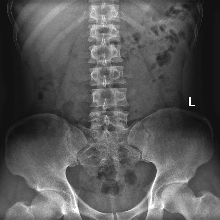

In [ ]:
img = cv.imread('/content/drive/MyDrive/spine_xray/레이블링/output/NORMAL/000002390000.png',cv.COLOR_BGR2GRAY)
height = 220
width = 220
dim = (width, height)
res = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
cv2_imshow(res)

In [ ]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = '/content/drive/MyDrive/spine_xray/레이블링/output/NORMAL/'

# 이미지 읽기
def img_read(src,file):
    height = 512
    width = 512
    dim = (width, height)
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    img = cv.resize(img, dim, interpolation=cv.INTER_AREA)
    return img

# src 경로에 있는 파일 명을 저장 
files = os.listdir(src)

X = []
Y = []

# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다. 
for file in tqdm(files): 
    X.append(img_read(src,file)/255.)
    Y.append(1) # nomal label : 1

# array로 데이터 변환
X = np.array(X)
Y = np.array(Y)

print('Normal shape:',np.shape(X))

  0%|          | 0/200 [00:00<?, ?it/s]

Normal shape: (200, 512, 512, 3)


In [ ]:
# Train set, Test set으로 나누기 
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=1,shuffle=True)

# 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(np.shape(X_train))
print(np.shape(X_test))

(160, 786432)
(40, 786432)


In [ ]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = '/content/drive/MyDrive/spine_xray/레이블링/output/OSTEOPOROSIS/'

# 이미지 읽기
def img_read(src,file):
    height = 512
    width = 512
    dim = (width, height)
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    img = cv.resize(img, dim, interpolation=cv.INTER_AREA)
    return img

# src 경로에 있는 파일 명을 저장합니다. 
files = os.listdir(src)

ANom = []
ANom_Y = []

# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다. 
for file in tqdm(files): 
    ANom.append(img_read(src,file)/255.)
    ANom_Y.append(0) # Anomal label : 0

# array로 데이터 변환
ANom = np.array(ANom)
ANom_Y = np.array(ANom_Y)
print('Anomaly shape:', np.shape(ANom_Y))

# 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
ANom_images = ANom.reshape((len(ANom), np.prod(ANom.shape[1:])))
print(np.shape(ANom_images))

  0%|          | 0/166 [00:00<?, ?it/s]

Anomaly shape: (166,)
(166, 786432)


In [ ]:
def AE():
    ## Encoder 구간
    model = tf.keras.Sequential()
    model.add(Dense(256, input_shape=(512*512*3,)))  # 입력계층
    model.add(Activation('relu'))      

    model.add(Dense(128))                       # 은닉계층
    model.add(Activation('relu'))

    ## Decoder 구간
    model.add(Dense(128))                        # 은닉계층
    model.add(Activation('relu'))

    model.add(Dense(512*512*3))                # 출력계층
    model.add(Activation('linear'))

    return model

In [ ]:
# model 함수 실행
model = AE()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               201326848 
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 786432)            1

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# 모델 구조 확정하고 컴파일 진행
model.compile(loss='MSE',                   # MSE : mean square error
              optimizer='adam',                 
              metrics=[ 'mae' ])            # MAE : mean absolute  error  

# model.fit을 써서 학습. 학습과정을 history에 저장
history = model.fit(X_train, X_train,
                    batch_size=10,
                    epochs=100,
                    validation_data=(X_test, X_test),
                    shuffle=True,
                    callbacks = [early_stopping_callback]
                    )

Epoch 1/100
16/16 [==============================] - 3s 146ms/step - loss: 0.0243 - mae: 0.1249 - val_loss: 0.0236 - val_mae: 0.1221
Epoch 2/100
16/16 [==============================] - 2s 138ms/step - loss: 0.0242 - mae: 0.1247 - val_loss: 0.0234 - val_mae: 0.1211
Epoch 3/100
16/16 [==============================] - 1s 65ms/step - loss: 0.0243 - mae: 0.1247 - val_loss: 0.0237 - val_mae: 0.1223
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.0243 - mae: 0.1249 - val_loss: 0.0237 - val_mae: 0.1220
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.0243 - mae: 0.1247 - val_loss: 0.0236 - val_mae: 0.1218
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.0243 - mae: 0.1247 - val_loss: 0.0235 - val_mae: 0.1218
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.0242 - mae: 0.1248 - val_loss: 0.0236 - val_mae: 0.1219
Epoch 8/100
16/16 [==============================] - 1s 63ms/step - loss: 

Normal Test data cost =  0.0233


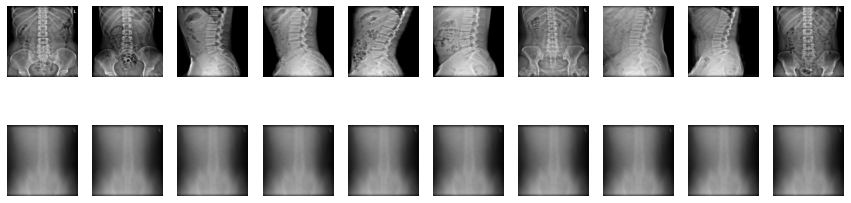

In [ ]:
# Normal data 복원 확인
test_score = model.evaluate(X_test, X_test, verbose=0) # loss 값 결과 확인
print('Normal Test data cost = ', '{:.4f}'.format(test_score[0]))

sample_size = 10                        # 보여줄 sample 갯수 설정
prediction1 = model.predict(X_test)      # test 데이터로 이미지 복원(predict 함수 사용)

# plot 하기
fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
for i in range(sample_size):
  org_img1 = X_test[i].reshape(512,512,3)
  rec_img1 = prediction1[i].reshape(512,512,3)
  
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  
  ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
  ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)

plt.show()

Abnormal Testing data cost =  0.0252


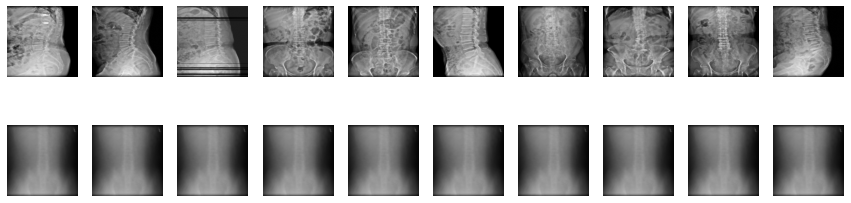

In [ ]:
# Abnormal data 복원
ANom_score = model.evaluate(ANom_images, ANom_images, verbose=0) # loss 값 결과 확인
print('Abnormal Testing data cost = ', '{:.4f}'.format(ANom_score[0]))

sample_size = 10                        # 보여줄 sample 갯수 설정
prediction2 = model.predict(ANom_images)      # test 데이터로 이미지 복원(predict 함수 사용)

# plot 하기
fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
for i in range(sample_size):
  org_img2 = ANom_images[i].reshape(512,512,3)
  rec_img2 = prediction2[i].reshape(512,512,3)
  
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  
  ax[0][i].imshow(org_img2, cmap=plt.cm.bone)
  ax[1][i].imshow(rec_img2, cmap=plt.cm.bone)

plt.show()

Normal Metric
       Normal_mse
count  200.000000
mean     0.024058
std      0.009371
min      0.009659
25%      0.017541
50%      0.021680
75%      0.027590
max      0.063375


Anomaly Metric
       Anomaly_mse
count   166.000000
mean      0.025192
std       0.009110
min       0.011065
25%       0.018121
50%       0.022791
75%       0.029847
max       0.054965




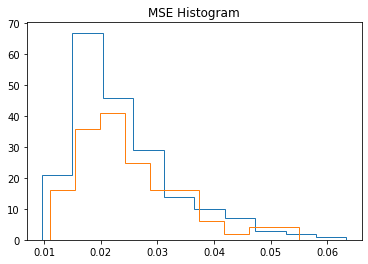

In [ ]:
# Normal data
Nom_data = np.concatenate((X_test, X_train), axis = 0)
Nom_pred = model.predict(Nom_data) # AE 이미지 결과값 
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse':Nom_pred_mse})
print(Nom_pred_mse_df.describe())

print('\n')

# Abnormal data 
ANom_pred = model.predict(ANom_images) # AE 이미지 결과값 
ANom_pred_mse = np.mean(np.power(ANom_images - ANom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
print(ANom_pred_mse_df.describe())

# 히스토그램 그리기
print('\n')
plt.figure()
plt.title('MSE Histogram') # 그림 이름 설정 
plt.hist(Nom_pred_mse, bins=10, facecolor='blue', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.hist(ANom_pred_mse, bins=10, facecolor='red', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.show()

In [ ]:
# 비교 가능하도록 데이터 설정 (data_3000 중 20%의 x_test + data_1000)
test_data = np.concatenate((X_test, ANom_images), axis = 0)
y_true = np.concatenate((Y_test, ANom_Y), axis = 0)

print(np.shape(test_data))
print(np.shape(y_true))

(206, 786432)
(206,)


In [ ]:
# 각 이미지별 loss를 구하여 설정한 임계값으로 조건을 제시한다.
test_data_pred = model.predict(test_data)
all_cost = np.mean(np.power(test_data - test_data_pred, 2), axis=1)

threshold = 0.019  # 설정한 임계값 (선택 가능)

y_pred = [] #y_pred list 초기화
for i in range(len(all_cost)):
    if all_cost[i] > threshold :
        y_pred.insert(i, 0) #임계점보다 높으면 positive(이상)
    else:
        y_pred.insert(i, 1) #임계점보다 낮으면 negative(정상)
        
print(y_pred[0:100]) #프린트로 값을 확인할 수 있다 (확인용으로 100개만).
print(np.shape(y_pred))

[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]
(206,)



 TP : 118 
 FN : 48 
 FP : 27 
 TN : 13 

Accuracy(정분류율=(TP+TN)/(TP+FN+FP+TN)): 63.59%
Error_rate(오분류율=(FP+FN)/(TP+FN+FP+TN): 36.41%
Prediction(정확도=TP/(TP+FP)): 81.38%
Recall(재현율,민감도=TP/(TP+FN)): 71.08%




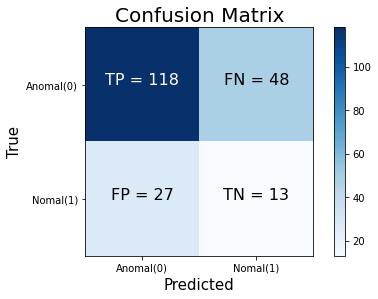

In [ ]:
from sklearn.metrics import confusion_matrix #confusion_matrix 라이브러리 임포트

con_mat = confusion_matrix(y_true, y_pred) #confusion_matrix 함수 실행

# Print the confusion matrix as text.
TP = con_mat[0][0] #둘다 Anomal, 0이며 예측값이 positive(이상값)이다.
FN = con_mat[0][1] #실제값과 예측값이 달랐으며, 예측값이 negative(정상값)이다.
FP = con_mat[1][0] #실제값과 예측값이 달랐으며, 예측값이 postive(이상값)이다.
TN = con_mat[1][1] #둘다 nomal, 1이며 예측값이 negative(정상값)이다.
print('\n',
      'TP :', TP, '\n', 
      'FN :', FN, '\n', 
      'FP :', FP, '\n', 
      'TN :', TN, '\n')

Accuracy = (TP+TN)/(TP+FN+FP+TN) #정분류율 : 전체관측치 중 실제값과 예측치가 일치하는 정도
print('Accuracy(정분류율=(TP+TN)/(TP+FN+FP+TN)):', '{:.2%}'.format(Accuracy))

Error_rate = (FP+FN)/(TP+FN+FP+TN) #오분류율 : 전체 관측치 중 실제값과 예측치가 다른 정보 (1-accuracy)
print('Error_rate(오분류율=(FP+FN)/(TP+FN+FP+TN):', '{:.2%}'.format(Error_rate))

Precirion = TP/(TP+FP) #정확도 : TRUE로 예측한 관측치 중 실제값이 TRUE인 정도
print('Prediction(정확도=TP/(TP+FP)):', '{:.2%}'.format(Precirion))

Recall = TP/(TP+FN) #재현율 : 실제값이 TRUE인 관측치 중 예측치가 적중한 정도, 모형의 완정성을 평가함, 민감도
print('Recall(재현율,민감도=TP/(TP+FN)):', '{:.2%}'.format(Recall))

print('\n')
# Confusion Matrix 표 그리기
plt.imshow(con_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Plot 구성하기
plt.title('Confusion Matrix', fontsize=20) # Plot 이름
plt.tight_layout()
plt.colorbar()
label=["Anomal(0)", "Nomal(1)"] # 라벨값
tick_marks = np.arange(len(label)) 
plt.xticks(tick_marks, label)
plt.yticks(tick_marks, label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)

# 표 안에 숫자 기입하는 방법
name = [['TP','FN'], ['FP', 'TN']]
thresh = con_mat.max() / 2.
for i in range(2):
     for j in range(2):
        plt.text(j, i, str(name[i][j])+" = "+str(con_mat[i, j]),
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] > thresh else "black",
                 fontsize=16)
    
plt.show()